## Práctica 3 - Deep Learning: Red Neuronal Convolucional (CNN)
***
Esta práctica ha sido llevada a cabo en solitario por Jaime Alonso Fernández (2024/2025) para la asignatura optativa "Aprendizaje Automático y Big Data" en el grado de "Ingeniería del Software - plan 2019" cursado en la Universidad Complutense de Madrid (UCM).
***

### Preguntas de búsqueda

## 1. Batch size = 4

El `batch_size=4` significa que el modelo procesa 4 imágenes a la vez durante el entrenamiento. Esto afecta al cálculo de los pesos de varias formas:

- **Cálculo del gradiente**: Se calcula el gradiente del loss con respecto a los pesos usando solo 4 muestras (en lugar de todo el dataset)
- **Actualización de pesos**: Los pesos se actualizan después de cada batch (4 imágenes) en lugar de después de todo el dataset
- **Memoria**: Un batch más pequeño consume menos memoria GPU
- **Ruido en los gradientes**: Proporciona una estimación más ruidosa del gradiente verdadero, lo que puede ayudar a escapar de mínimos locales

## 2. Shuffle en train vs test

- **Conjunto de entrenamiento (shuffle=True)**:
  - Mezclar los datos evita que el modelo aprenda patrones basados en el orden de los datos
  - Ayuda a que el entrenamiento no se vea afectado por cualquier ordenamiento previo de los datos
  - Mejora la generalización durante el entrenamiento

- **Conjunto de test (shuffle=False)**:
  - No es necesario mezclar porque no se está aprendiendo
  - Mantener el orden original puede ser útil para analizar resultados consistentes
  - Facilita la comparación entre ejecuciones

## 3. Clase Net

### a. Constructor
```
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # Capa conv: 3 canales entrada (RGB), 6 filtros de salida, kernel 5x5
        self.pool = nn.MaxPool2d(2, 2)   # Pooling: kernel 2x2, stride 2 (reduce tamaño a la mitad)
        self.conv2 = nn.Conv2d(6, 16, 5) # Capa conv: 6 canales entrada, 16 filtros salida, kernel 5x5
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # Fully connected: 16*5*5 entradas (por reducciones previas), 120 salidas
        self.fc2 = nn.Linear(120, 84)    # FC: 120 entradas, 84 salidas
        self.fc3 = nn.Linear(84, 10)     # FC: 84 entradas, 10 salidas (una por clase)
```

### b. Forward Propagation
```
def forward(self, x):
    x = self.pool(F.relu(self.conv1(x))) # 1. Aplica conv1, ReLU y max pooling
    x = self.pool(F.relu(self.conv2(x))) # 2. Aplica conv2, ReLU y max pooling
    x = x.view(-1, 16 * 5 * 5)           # 3. Aplana el tensor para la capa FC
    x = F.relu(self.fc1(x))              # 4. Aplica primera capa FC + ReLU
    x = F.relu(self.fc2(x))              # 5. Aplica segunda capa FC + ReLU
    x = self.fc3(x)                      # 6. Capa final sin activación (se usará CrossEntropyLoss)
    return x
```

## 4. Cálculo de Gradientes y Actualización de pesos
loss.backward()  # Calcula los gradientes 

optimizer.step()  # Actualiza los pesos 

Pre-requisitos:

- Llamar a optimizer.zero_grad() para resetear los gradientes de la iteración anterior

- Calcular el loss con criterion(outputs, labels)

- Ejecutar loss.backward() para calcular los nuevos gradientes

## 5. Estructura de outputs = net(images)
El tensor outputs tiene forma [batch_size, 10] donde:

- batch_size: Número de imágenes procesadas (4 en este caso)

- 10: Número de clases en CIFAR-10 (una probabilidad por clase)

Cada fila contiene los logits (valores antes de softmax) para una imagen, representando las "puntuaciones" que el modelo asigna a cada clase. Para obtener probabilidades se necesitaría aplicar softmax, pero CrossEntropyLoss lo hace internamente.

### Importación las librerías

Se importan las librerias necesarias:
-  PyTorch para la construcción y entrenamiento de la red neuronal.
-  torchvision para cargar el dataset MNIST.
-  matplotlib para visualizar los resultados.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

### Preprocesamiento de Datos

Cargamos los datos de **MNIST** haciendo uso de una API de torchvision y definimos una transformación que convierte las imágenes en tensores normalizando los valores de píxeles. 

In [4]:
# Configuración de transformaciones
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Cargar datasets
trainset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
testset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)


Pasamos a definir las dos configuraciones distintas requeridas para la red neuronal, variando:
- **batch_size**  
- Número de capas convolucionales 
- Número de capas conectadas 
- Tamaño de kernel 
- Número de filtros (kernels) 
- Tamaños para reducir las matrices en la capa de pooling 
- Números de neuronas en las capas ocultas de las capas conectadas 
- Tasa de aprendizaje 
- Número de **epochs**

In [5]:
# Configuraciones
config1 = {
    "batch_size": 64,
    "conv_layers": [(32, 3), (64, 3)],  # (num_filtros, tamaño_kernel)
    "fc_layers": [128],
    "pool_size": 2,
    "lr": 0.001,
    "epochs": 5
}

config2 = {
    "batch_size": 128,
    "conv_layers": [(16, 5), (32, 5), (64, 3)],
    "fc_layers": [256, 128],
    "pool_size": 3,
    "lr": 0.0005,
    "epochs": 15
}


### Creación del Modelo

Definimos una funcion encargada para la creación del modelo acorde a la configuración que se le proporcione. Esto incluye capas convolucionales, capas de pooling, capas totalmente conectadas y funciones de activación ReLU.

In [6]:
import torch
import torch.nn as nn

def create_model(config):
    
    # Lista donde se almacenarán las capas de la red
    layers = []  
    # Las imágenes del MNIST están en escala de grises, por lo que tiene un solo canal
    in_channels = 1 

    # Definición de las capas convolucionales
    for out_channels, kernel_size in config['conv_layers']:
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, padding=kernel_size // 2))
        # Función de activación ReLU
        layers.append(nn.ReLU())  
        # Reducimos la dimensión de la imagen
        layers.append(nn.MaxPool2d(config['pool_size']))  
        # Actualizamos el número de canales para la siguiente capa
        in_channels = out_channels  
    
    # Calcular el tamaño aplanado después de las capas convolucionales
    with torch.no_grad():  # Desactiva el cálculo de gradientes (mejora el rendimiento)
        # Tensor de prueba con el tamaño de las imágenes MNIST (estas son 28x28)
        test_tensor = torch.zeros(1, 1, 28, 28)  
        for layer in layers:
            # Pasamos el tensor a través de las capas
            test_tensor = layer(test_tensor)  
        # Calculamos el número de elementos del tensor resultante
        flattened_size = test_tensor.numel() 
    
    # Aplanamos la capa de salida a un vector
    layers.append(nn.Flatten())

    # Definición de las capas totalmente conectadas (Fully Connected Layers)
    # Número de características de entrada después del aplanamiento
    in_features = flattened_size  
    for out_features in config['fc_layers']:
        # Capa totalmente conectada
        layers.append(nn.Linear(in_features, out_features)) 
        # Función de activación ReLU
        layers.append(nn.ReLU())  
        # Actualizamos el número de neuronas para la siguiente capa
        in_features = out_features  
    
    # Capa de salida con 10 neuronas (para las 10 clases del dataset MNIST)
    layers.append(nn.Linear(in_features, 10))  
    
    return nn.Sequential(*layers)  # Devolvemos el modelo como una secuencia de capas


### Entreno y Testeo del Modelo

Entrenamos el modelo utilizando el optimizador Adam y la función de pérdida la definimos a ser **CrossEntropyLoss**. Finalmente iteramos por los epochs definidos y hacemos un entreno por cada uno de ellos sobre el modelo.

Al estar usando el mismo modelo, las correcciones del **backwards propagation** aplican a todos los entrenos aunque al inicio de cada uno reiniciemos la corrección.

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_model(model, config, trainloader):    
    # Definimos la función de pérdida (CrossEntropyLoss es adecuada para clasificación multiclase)
    criterion = nn.CrossEntropyLoss()
    
    
    # Definimos el optimizador (Adam es una buena elección por su eficiencia y adaptación del learning rate)
    optimizer = optim.Adam(model.parameters(), lr=config["lr"])
    
    # Ponemos el modelo en modo de entrenamiento
    model.train()
    
    # Bucle principal de entrenamiento
    for epoch in range(config["epochs"]):
        running_loss = 0.0  # Variable para acumular la pérdida en cada época
        
        # Iteramos sobre los lotes de datos
        for images, labels in trainloader:
            # Reseteamos los gradientes previos
            optimizer.zero_grad() 
            # Hacemos una predicción con el modelo
            outputs = model(images)  
            # Calculamos la pérdida entre la predicción y las etiquetas reales
            loss = criterion(outputs, labels)  
            # Hacemos backwards propagation
            loss.backward()  
            # Actualizamos los pesos del modelo
            optimizer.step()  
            
            # Acumulamos la pérdida/error
            running_loss += loss.item()  
        
        # Imprimimos la pérdida promedio por época
        print(f"Epoch {epoch+1}/{config['epochs']}, Loss: {running_loss / len(trainloader):.4f}")


Definimos también una funcion que se encarge de probar la precisión final del modelo sobre el dataset de test

In [8]:
def evaluate_model(model, testloader):
    
    # Ponemos el modelo en modo evaluación (desactiva dropout y batch normalization)
    model.eval()  
    # Listas para almacenar las etiquetas reales y predichas
    y_true, y_pred = [], []  
    
    # Desactivamos el cálculo de gradientes ya que no nos hace falta
    with torch.no_grad():  
        for images, labels in testloader:
            # Generamos las predicciones del modelo
            outputs = model(images)  
            # Obtenemos la clase con mayor probabilidad
            _, predicted = torch.max(outputs, 1)  
            # Convertimos las etiquetas reales a una lista
            y_true.extend(labels.numpy())  
            # Convertimos las predicciones a una lista
            y_pred.extend(predicted.numpy())  
    
    # Cálculo de métricas de evaluación
    # Sacamos la precisión total
    total_accuracy = accuracy_score(y_true, y_pred)  
    class_accuracies = [
        accuracy_score((np.array(y_true) == i), (np.array(y_pred) == i)) 
        for i in range(10)  # Calculamos la precisión para cada una de las 10 clases
    ]
    
    return total_accuracy, class_accuracies

### Preparación para la ejecución

Antes de ejecutar, vamos a definir primero una función que nos permita mostrar un histograma con los resultados y después un 'ejecutador' que nos ejecute entreno y test con la configuración que se le pase


In [9]:
# Función para mostrar resultados
def plot_results(class_accuracies, config_name):
    plt.figure(figsize=(10, 5))
    plt.bar(range(10), class_accuracies, tick_label=range(10))
    plt.title(f"Accuracy por clase - {config_name}")
    plt.xlabel("Dígito")
    plt.ylabel("Accuracy")
    plt.show()

# Proceso completo para una configuración
def run_configuration(config, config_name):
    print(f"\n=====|=== Ejecutando {config_name} ===|=====")
    
    # Preparar dataloaders
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=config["batch_size"], shuffle=True)
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=config["batch_size"], shuffle=False)
    
    # Crear y entrenar modelo
    model = create_model(config)
    train_model(model, config, trainloader)
    
    # Evaluar modelo
    total_accuracy, class_accuracies = evaluate_model(model, testloader)
    print(f"Accuracy total {config_name}: {total_accuracy:.4f}")
    for i, accuracy in enumerate(class_accuracies):
        print(f"Precision para {i}: {accuracy}")
    
    
    # Mostrar resultados
    plot_results(class_accuracies, config_name)

### Ejecución del modelo


=====|=== Ejecutando Configuración 1 ===|=====
Epoch 1/5, Loss: 0.1585
Epoch 2/5, Loss: 0.0450
Epoch 3/5, Loss: 0.0308
Epoch 4/5, Loss: 0.0213
Epoch 5/5, Loss: 0.0172
Accuracy total Configuración 1: 0.9886
Precision para 0: 0.9983
Precision para 1: 0.9981
Precision para 2: 0.9982
Precision para 3: 0.9985
Precision para 4: 0.9982
Precision para 5: 0.9977
Precision para 6: 0.9977
Precision para 7: 0.9984
Precision para 8: 0.9955
Precision para 9: 0.9966


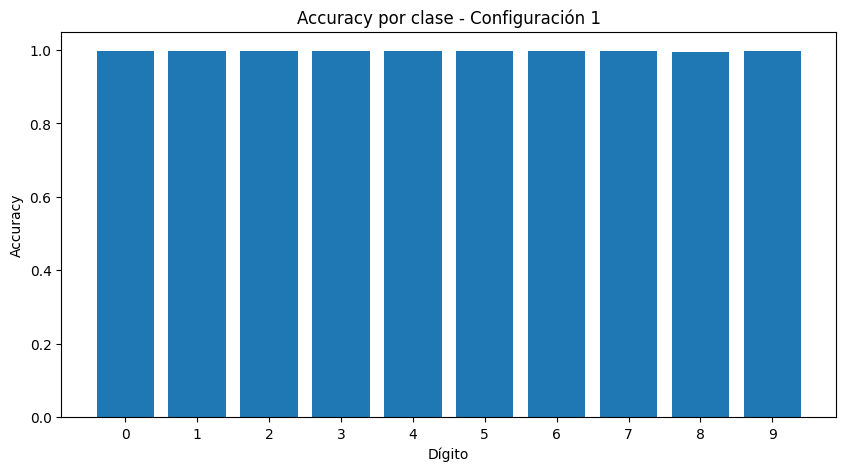


=====|=== Ejecutando Configuración 2 ===|=====
Epoch 1/15, Loss: 0.4818
Epoch 2/15, Loss: 0.0956
Epoch 3/15, Loss: 0.0680
Epoch 4/15, Loss: 0.0527
Epoch 5/15, Loss: 0.0460
Epoch 6/15, Loss: 0.0376
Epoch 7/15, Loss: 0.0315
Epoch 8/15, Loss: 0.0302
Epoch 9/15, Loss: 0.0261
Epoch 10/15, Loss: 0.0234
Epoch 11/15, Loss: 0.0209
Epoch 12/15, Loss: 0.0200
Epoch 13/15, Loss: 0.0176
Epoch 14/15, Loss: 0.0167
Epoch 15/15, Loss: 0.0151
Accuracy total Configuración 2: 0.9902
Precision para 0: 0.9986
Precision para 1: 0.999
Precision para 2: 0.9975
Precision para 3: 0.9988
Precision para 4: 0.9979
Precision para 5: 0.9984
Precision para 6: 0.9979
Precision para 7: 0.998
Precision para 8: 0.998
Precision para 9: 0.9963


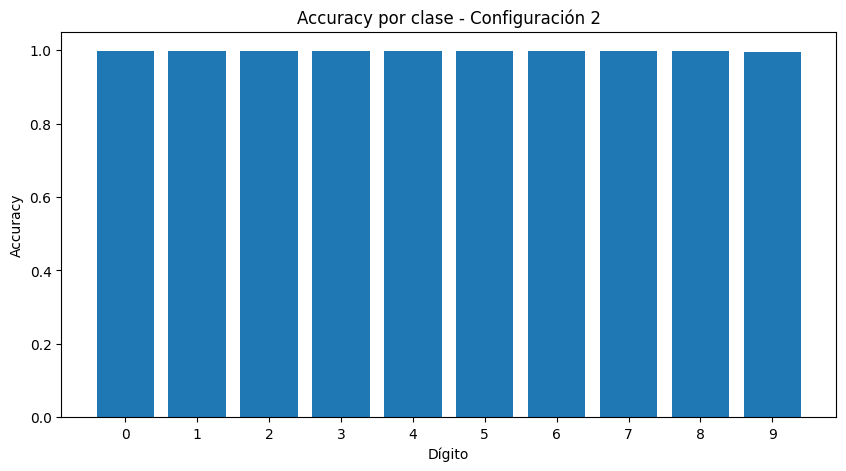

In [10]:
# Ejecutar ambas configuraciones
run_configuration(config1, "Configuración 1")
run_configuration(config2, "Configuración 2")

Finalmente para determinar qué configuración es mejor, compararemos las métricas clave de ambas configuraciones:

Comparación de Métricas:


Pérdida (Loss) Final:

- Configuración 1: 0.0172 (en 5 epoch).

- Configuración 2: 0.0151 (en 15 epoch).

**La Configuración 2 logra un menor error final.**

Precisión Total (Accuracy):

- Configuración 1: 98.86%.

- Configuración 2: 99.02%.

**La Configuración 2 tiene una precisión ligeramente superior.**

Precisión por Clase (Precision):

Ambas configuraciones tienen precisiones muy altas (superiores al 99% en la mayoría de clases), pero la Configuración 2 muestra mejor desempeño en clases como 1 (99.9% vs 99.81%) y 3 (99.88% vs 99.85%), mientras que la Configuración 1 es ligeramente mejor en 8 (99.55% vs 99.8%) y 9 (99.66% vs 99.63%).

**La Configuración 2 es más consistente en la mayoría de clases.**

Eficiencia (epoch vs. Rendimiento):

- Configuración 1 alcanza un buen rendimiento en solo 5 epoch.

- Configuración 2 necesita 10 epoch más para lograr una mejora sustanciañ.

**La Configuración 1 es más eficiente en tiempo/computación.**

***Conclusión:***
Si priorizas la mejor **precisión** y menor pérdida, la **Configuración 2** es ligeramente mejor

Si buscas **eficiencia**, la **Configuración 1** es mejor.

Finalmente destacar que me llama la atención como los valores que se dificultan van cambiando en función de la configuración, lo cual tiene bastante sentido pero no me deja de resultar curioso.

***
**Jaime Alonso Fernández**  
**Universidad Complutense de Madrid**  
**Grado en Ingeniería del Software (Plan 2019)**  
**Asignatura de Aprendizaje Automático y Big Data**
***

